In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import norm
from data import wirtual
import random

In [2]:
wirtual_flat = [item for sublist in wirtual for item in sublist]
print(len(wirtual))

def rolling_avg(sequence, window_size):
    # Initialize the rolling average array
    rolling_avg = np.zeros_like(sequence, dtype=float)

    # Compute rolling average
    for i in range(len(sequence)):
        if i < window_size - 1:
            # For the first few elements, average the elements from the start to the current position
            rolling_avg[i] = np.mean(sequence[:i+1])
        else:
            # For the rest, compute the average of the window
            rolling_avg[i] = np.mean(sequence[i-window_size+1:i+1])
    return rolling_avg

def rolling_avg_both_sides(sequence, window_size):
    # Initialize the rolling average array
    rolling_avg = np.zeros_like(sequence, dtype=float)

    # Compute rolling average
    for i in range(len(sequence)):
        start = i-window_size//2+1
        end = start+window_size
        if start<0:
            start=0
        if end > len(sequence):
            end=len(sequence)
        rolling_avg[i] = np.mean(sequence[start:end])
    return rolling_avg

def remove_repeated_elements(arr):
    if not arr:
        return []
    result = [arr[0]]
    for el in arr:
        if el != result[-1]:
            result.append(el)
    return result

def exp_smoothing_average(sequence, alpha=0.05):
    avg = np.zeros_like(sequence, dtype=float)
    for i in range(1, len(sequence)):
        avg[i] = alpha*sequence[i] + (1-alpha)*(avg[i-1])
    return avg

def logistic_curve(n, low, high, shift, speed):
    return low + (high-low) / (1 + np.exp(-speed * (n-shift)))

def loss_logistic(params, sequence):
    low, high, shift, speed = params
    n = np.arange(len(sequence))
    predicted_probs = logistic_curve(n, low, high, shift, speed)
    loss = np.mean((sequence - predicted_probs)**2)
    return np.sum(loss)

class Floor:
    
    def __init__(self):
        self.floor = None
        self.successes = None
        self.params = None
        self.prob = None
        self.fail_distribution = None
            
    @classmethod
    def from_data(cls, data, floor):
        obj = Floor()
        obj.floor = floor
        
        # Calculate successes and fail distribution
        obj.successes = []
        obj.fail_distribution = {i: 0 for i in range(floor+1)}
        for i in range(len(data)-1):
            if data[i] == floor:
                if data[i+1] == floor+1:
                    obj.successes.append(1)
                else:
                    obj.successes.append(0)
                    obj.fail_distribution[data[i+1]] += 1
                    
        # Compute rolling average
        window_size = 20
        obj.prob = rolling_avg(obj.successes, window_size)
        #obj.prob = exp_smoothing_average(obj.successes)
        
        # Train model
        initial_params = [0.1, 0.1, 0.9, 0.9]
        bounds = [(-10, 1), (0, 1), (-100, 300), (0, 30)]
        result = minimize(loss_logistic, initial_params, args=(obj.prob,), bounds=bounds, method='L-BFGS-B')
        #result = minimize(loss_logistic, initial_params, args=(obj.prob,), method='L-BFGS-B')
        if result.success:
            obj.params = result.x
        else:
            print("Optimization failed:", result.message)
        return obj
            
    @classmethod
    def from_params(cls, floor, low, high, shift, speed):
        obj = Floor()
        obj.floor = floor
        obj.successes = list(range(100))
        obj.params = (low, high, shift, speed)
        obj.fail_distribution = {i:1 for i in range(floor)}
        return obj
            
    def simulate_one_step(self, attempt):
        p = logistic_curve(attempt, *self.params)
        if random.random() <= p:
            return self.floor + 1
        else:
            keys = list(self.fail_distribution.keys())
            weights = list(self.fail_distribution.values())
            sample = random.choices(keys, weights=weights, k=1)[0]
            return sample
            
    def plot(self):
        # Generate x values
        if self.prob is not None:
            x_values = np.linspace(0, len(self.prob), 400)
        else:
            x_values = np.linspace(0, 100, 400)

        low, high, shift, speed = self.params

        # Calculate y values
        y_values = logistic_curve(x_values, low, high, shift, speed)

        # Plotting the result
        plt.figure(figsize=(5, 3))
        #plt.plot(sequence, label='Original Data')
        if self.prob is not None:
            plt.plot(self.prob, label='Rolling Average', color='red')
        plt.plot(x_values, y_values, label='Logistic Curve')
        plt.title(f'Floor {self.floor}')
        plt.xlabel('Attempts')
        plt.ylabel('Success Probability')
        plt.ylim(0, 1.05)
        plt.grid(True)
        plt.legend()
        plt.show()

68


In [3]:
wirtual_flat = remove_repeated_elements(wirtual_flat)
wirtual_first_time_reached_floor = []
for i in range(18):
    try:
        wirtual_first_time_reached_floor.append(wirtual_flat.index(i))
    except:
        pass
wirtual_first_time_reached_floor

[0, 1, 20, 195, 257, 564, 612, 1112, 1772, 2116]

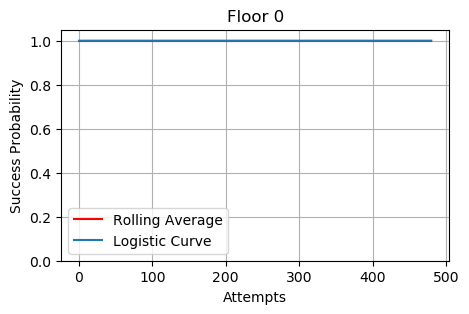

1.00
1.00
0.72
0.91


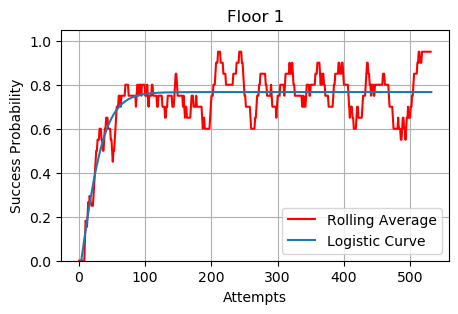

-0.85
0.77
1.41
0.05


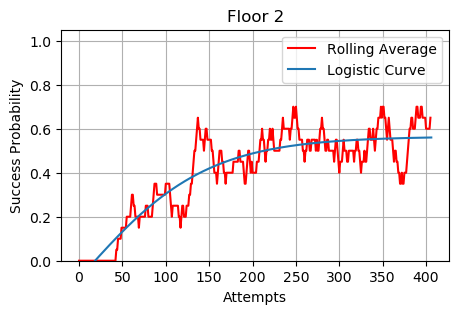

-0.72
0.56
1.38
0.01


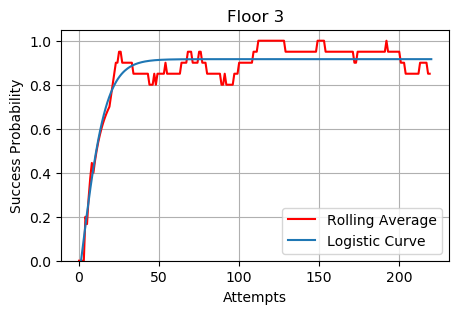

-0.91
0.92
1.34
0.13


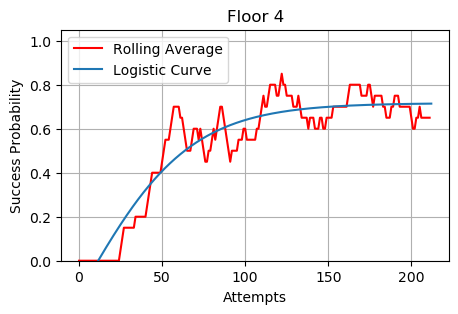

-0.98
0.72
1.23
0.03


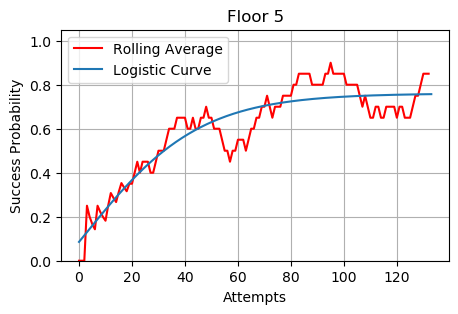

-0.55
0.76
1.18
0.05


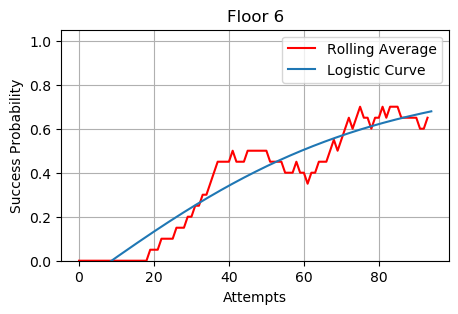

-1.02
0.83
0.76
0.03


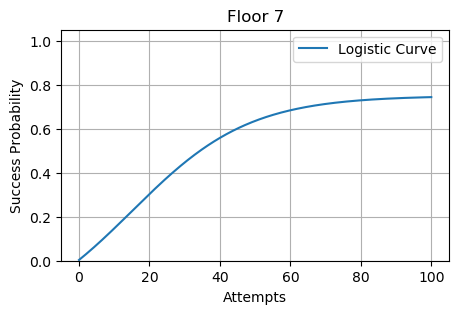

-0.30
0.75
15.00
0.06


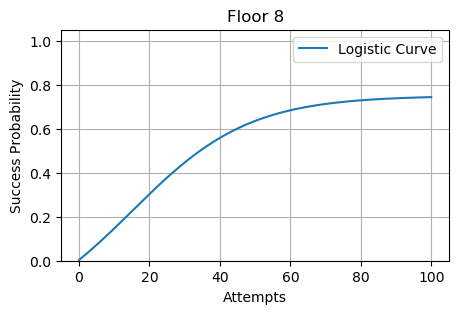

-0.30
0.75
15.00
0.06


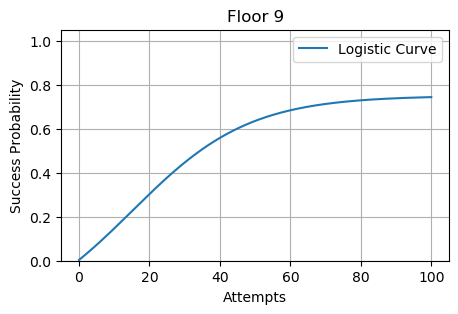

-0.30
0.75
15.00
0.06


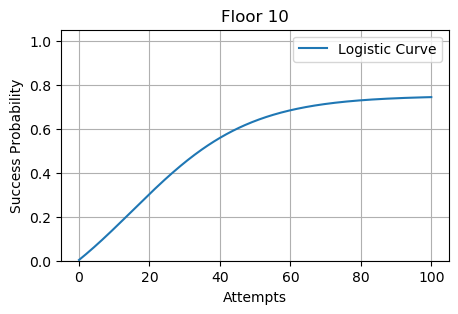

-0.30
0.75
15.00
0.06


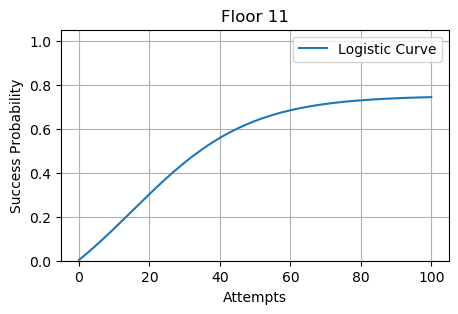

-0.30
0.75
15.00
0.06


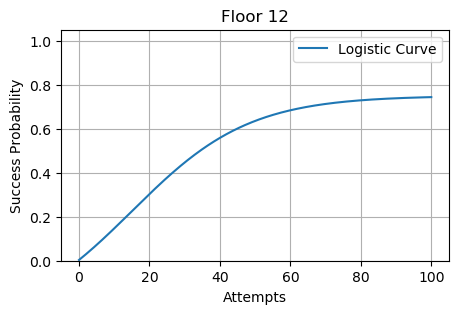

-0.30
0.75
15.00
0.06


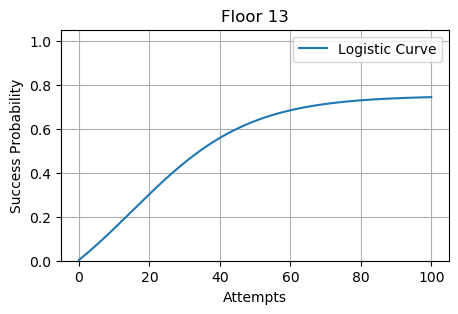

-0.30
0.75
15.00
0.06


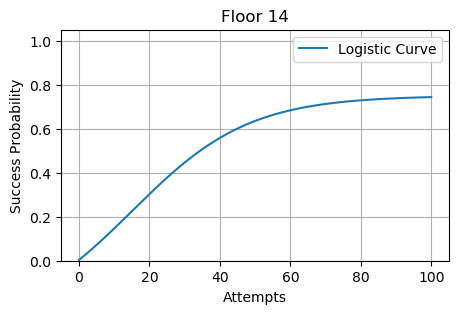

-0.30
0.75
15.00
0.06


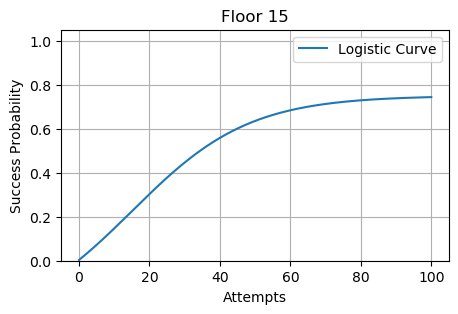

-0.30
0.75
15.00
0.06


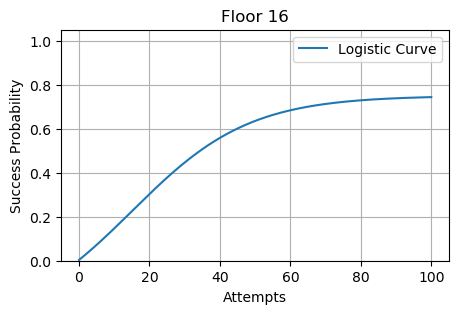

-0.30
0.75
15.00
0.06


In [4]:
floors = []
for i in range(7):
    floors.append(Floor.from_data(wirtual_flat, i))
    
for i in range(7, 17):
    floors.append(Floor.from_params(i, -0.3, 0.75, 15, 0.06))
    
for floor in floors:
    floor.plot()
    for param in floor.params:
        print(f"{param:.2f}")

In [5]:
prod = 1.0
for i in range(17):
    prod *= floors[i].params[1]
    print(f"Assuming enough practice, the chance to go through to floor {i+1} without fall: {prod}")

Assuming enough practice, the chance to go through to floor 1 without fall: 1.0
Assuming enough practice, the chance to go through to floor 2 without fall: 0.7666333880704087
Assuming enough practice, the chance to go through to floor 3 without fall: 0.4330053642069783
Assuming enough practice, the chance to go through to floor 4 without fall: 0.3967175112723016
Assuming enough practice, the chance to go through to floor 5 without fall: 0.2843041471789264
Assuming enough practice, the chance to go through to floor 6 without fall: 0.21622753534903572
Assuming enough practice, the chance to go through to floor 7 without fall: 0.17854619657096918
Assuming enough practice, the chance to go through to floor 8 without fall: 0.1339096474282269
Assuming enough practice, the chance to go through to floor 9 without fall: 0.10043223557117018
Assuming enough practice, the chance to go through to floor 10 without fall: 0.07532417667837762
Assuming enough practice, the chance to go through to floor 

In [6]:
results = []
for sim in range(1000):
    attempts = {i:0 for i in range(17)}
    first_time_reached_floor = [0]
    highest_reached_floor = 0
    current_floor = 0
    counter = 0
    while current_floor < 17:
        attempt_number = attempts[current_floor]
        new_floor = floors[current_floor].simulate_one_step(attempt_number)
        attempts[current_floor] += 1
        current_floor = new_floor
        counter += 1
        if current_floor > highest_reached_floor:
            highest_reached_floor = current_floor
            first_time_reached_floor.append(counter)
    results.append(first_time_reached_floor)
    if sim % 100 == 0:
        print(f"Simulations done: {sim}")

Simulations done: 0
Simulations done: 100
Simulations done: 200
Simulations done: 300
Simulations done: 400
Simulations done: 500
Simulations done: 600
Simulations done: 700
Simulations done: 800
Simulations done: 900


Steps per hour: 31.28
Minimum number of steps: 1 (0 hours)
Mean number of steps: 1 (0 hours)
Maximum number of steps: 1 (0 hours)
Standard deviation: 0 (0 hours)


/home/leif/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


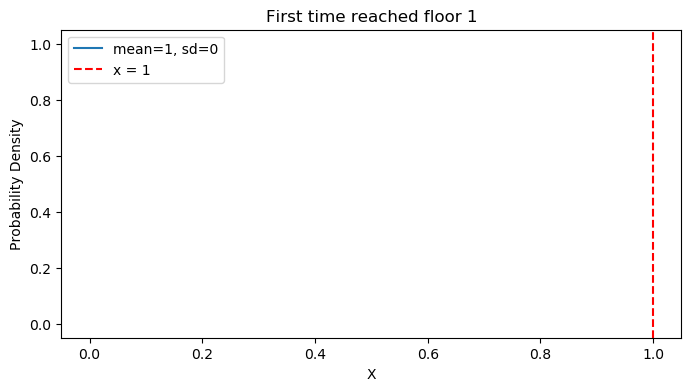

Steps per hour: 31.28
Minimum number of steps: 10 (0 hours)
Mean number of steps: 25 (1 hours)
Maximum number of steps: 60 (2 hours)
Standard deviation: 9 (0 hours)


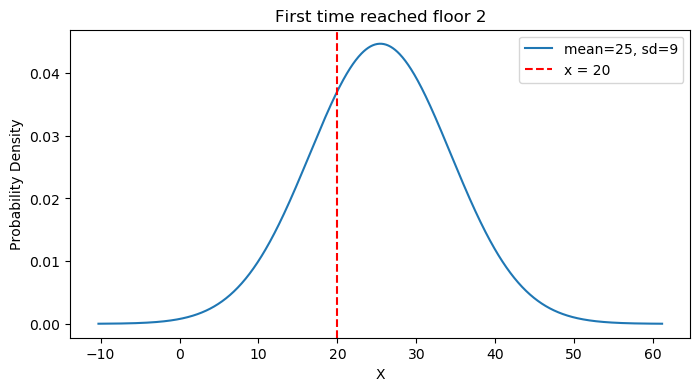

Steps per hour: 31.28
Minimum number of steps: 109 (3 hours)
Mean number of steps: 190 (6 hours)
Maximum number of steps: 342 (11 hours)
Standard deviation: 38 (1 hours)


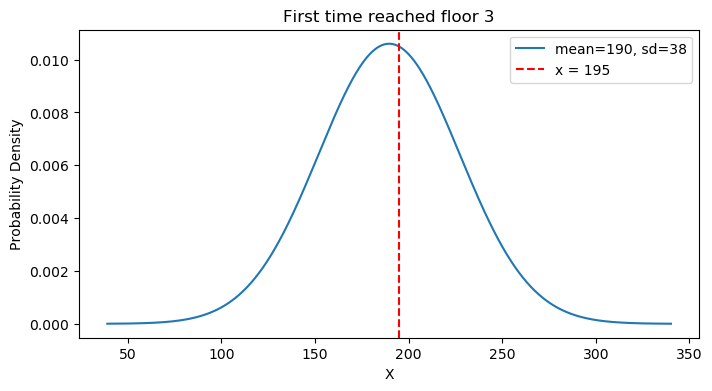

Steps per hour: 31.28
Minimum number of steps: 147 (5 hours)
Mean number of steps: 328 (10 hours)
Maximum number of steps: 495 (16 hours)
Standard deviation: 56 (2 hours)


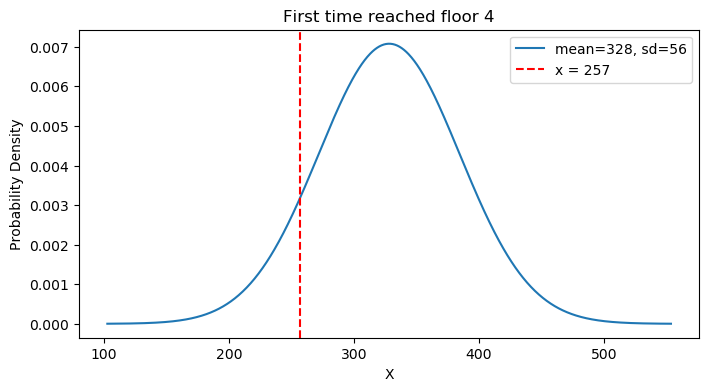

Steps per hour: 31.28
Minimum number of steps: 436 (14 hours)
Mean number of steps: 613 (20 hours)
Maximum number of steps: 820 (26 hours)
Standard deviation: 66 (2 hours)


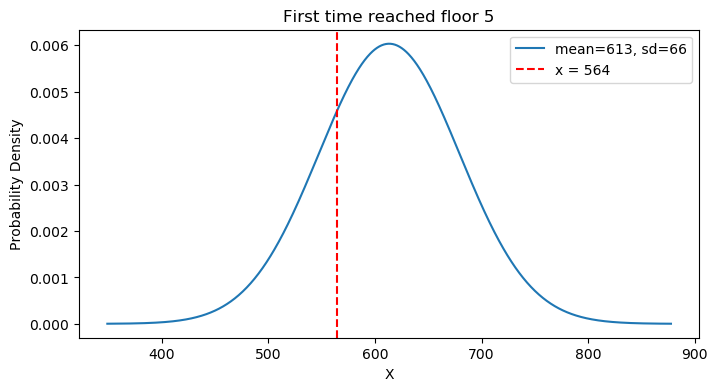

Steps per hour: 31.28
Minimum number of steps: 476 (15 hours)
Mean number of steps: 774 (25 hours)
Maximum number of steps: 1236 (40 hours)
Standard deviation: 116 (4 hours)


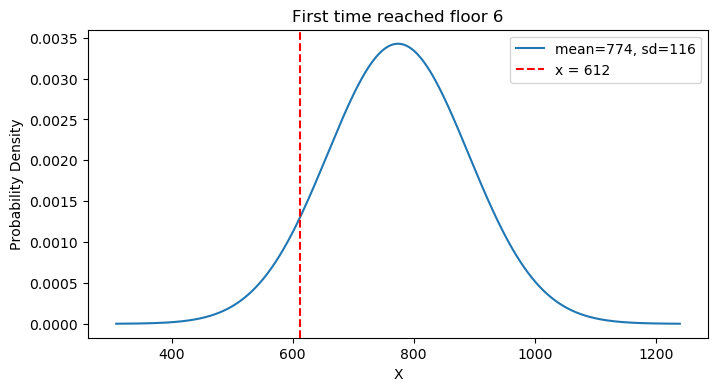

Steps per hour: 31.28
Minimum number of steps: 974 (31 hours)
Mean number of steps: 1381 (44 hours)
Maximum number of steps: 1869 (60 hours)
Standard deviation: 145 (5 hours)


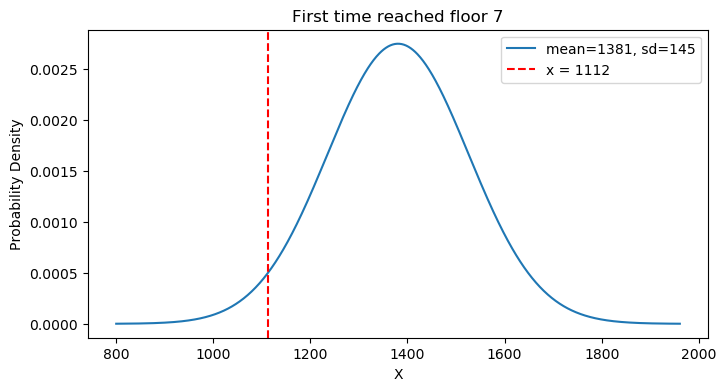

Steps per hour: 31.28
Minimum number of steps: 1207 (39 hours)
Mean number of steps: 1825 (58 hours)
Maximum number of steps: 2450 (78 hours)
Standard deviation: 205 (7 hours)


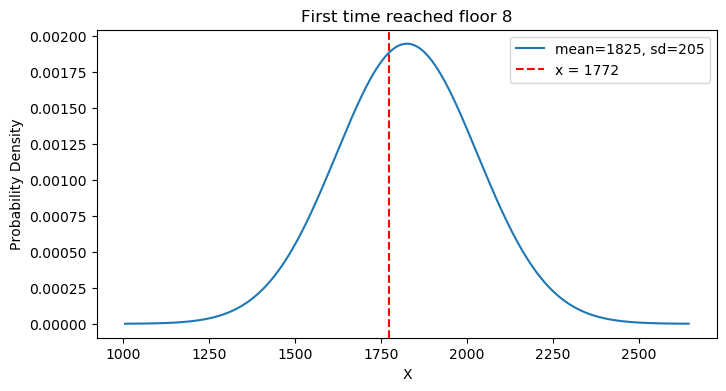

Steps per hour: 31.28
Minimum number of steps: 1648 (53 hours)
Mean number of steps: 2372 (76 hours)
Maximum number of steps: 3073 (98 hours)
Standard deviation: 244 (8 hours)


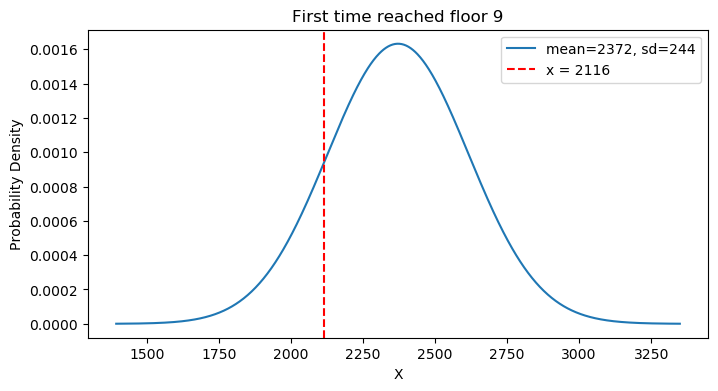

Steps per hour: 31.28
Minimum number of steps: 1977 (63 hours)
Mean number of steps: 3001 (96 hours)
Maximum number of steps: 4178 (134 hours)
Standard deviation: 296 (9 hours)


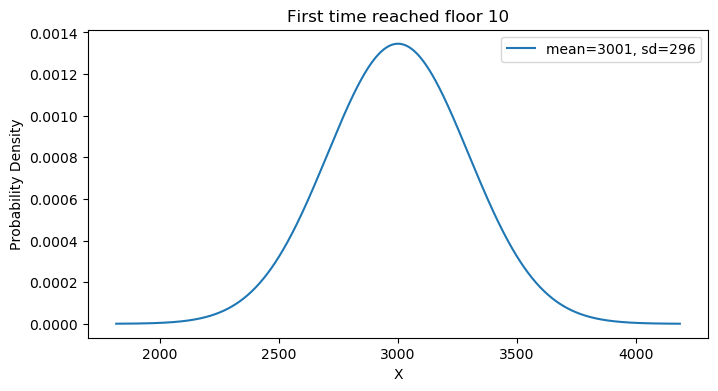

Steps per hour: 31.28
Minimum number of steps: 2547 (81 hours)
Mean number of steps: 3746 (120 hours)
Maximum number of steps: 4968 (159 hours)
Standard deviation: 374 (12 hours)


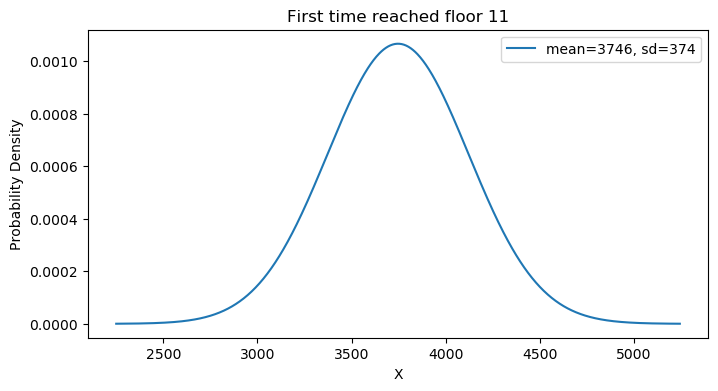

Steps per hour: 31.28
Minimum number of steps: 3291 (105 hours)
Mean number of steps: 4677 (150 hours)
Maximum number of steps: 6494 (208 hours)
Standard deviation: 472 (15 hours)


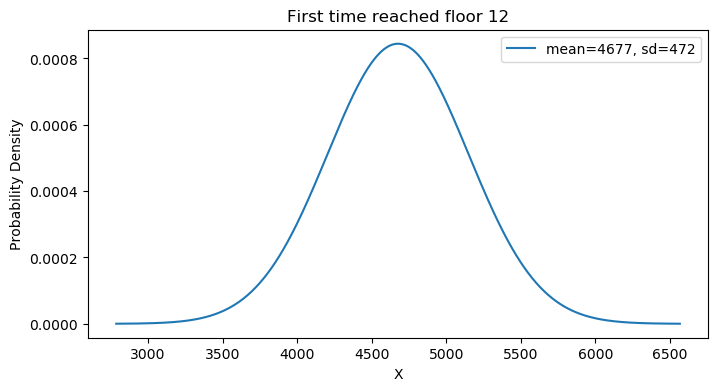

Steps per hour: 31.28
Minimum number of steps: 4320 (138 hours)
Mean number of steps: 5883 (188 hours)
Maximum number of steps: 7973 (255 hours)
Standard deviation: 592 (19 hours)


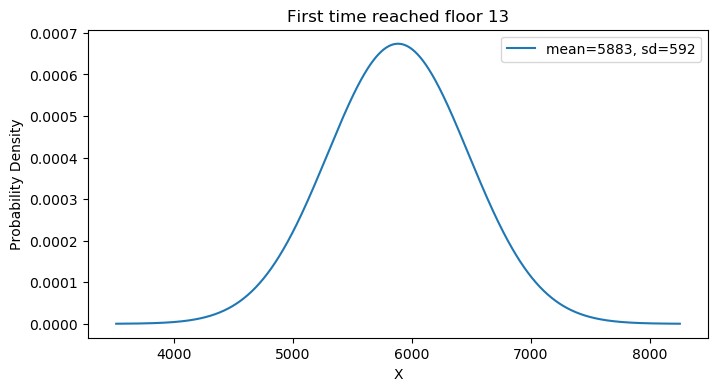

Steps per hour: 31.28
Minimum number of steps: 4667 (149 hours)
Mean number of steps: 7425 (237 hours)
Maximum number of steps: 10224 (327 hours)
Standard deviation: 772 (25 hours)


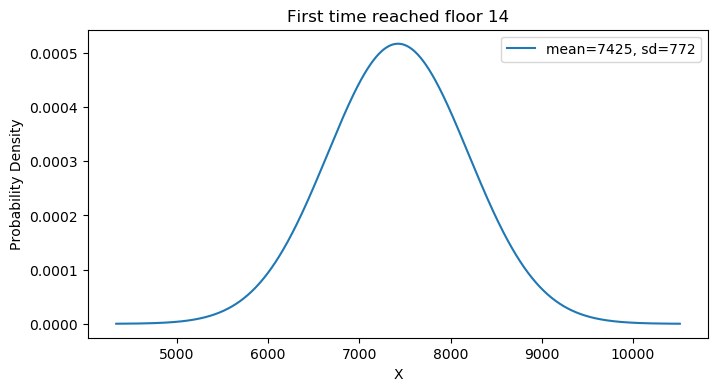

Steps per hour: 31.28
Minimum number of steps: 6604 (211 hours)
Mean number of steps: 9313 (298 hours)
Maximum number of steps: 12378 (396 hours)
Standard deviation: 1006 (32 hours)


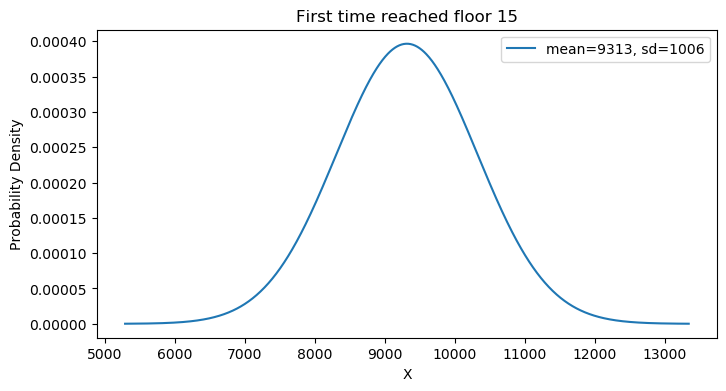

Steps per hour: 31.28
Minimum number of steps: 7737 (247 hours)
Mean number of steps: 11869 (379 hours)
Maximum number of steps: 15569 (498 hours)
Standard deviation: 1234 (39 hours)


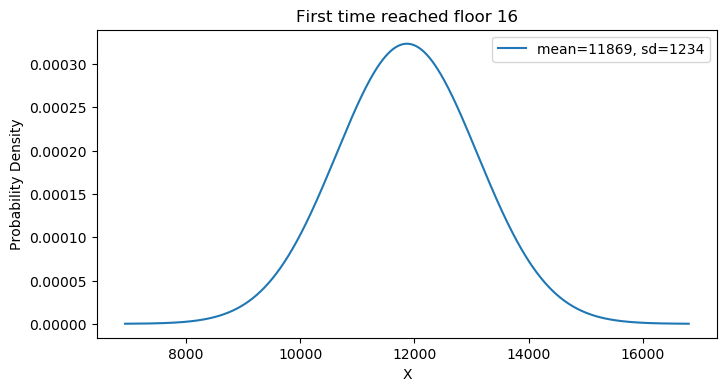

Steps per hour: 31.28
Minimum number of steps: 10493 (335 hours)
Mean number of steps: 14983 (479 hours)
Maximum number of steps: 19629 (628 hours)
Standard deviation: 1606 (51 hours)


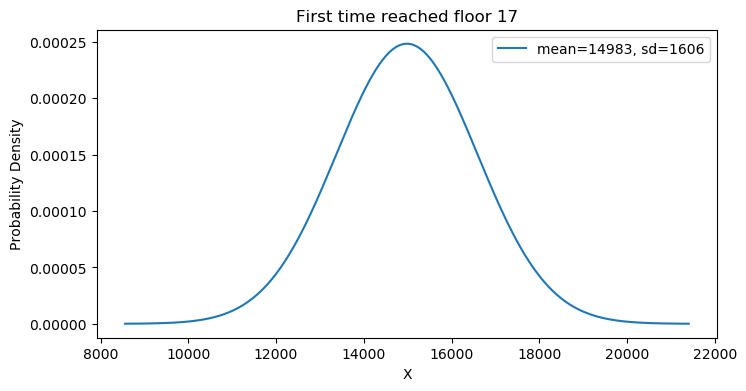

In [7]:
def gauss(mean, sd, title=None, highlight=None):
    x_values = np.linspace(mean - 4*sd, mean + 4*sd, 1000)
    y_values = norm.pdf(x_values, mean, sd)
    plt.figure(figsize=(8, 4))
    plt.plot(x_values, y_values, label=f'mean={mean:.0f}, sd={sd:.0f}')
    if highlight is not None:
        plt.axvline(x=highlight, color='r', linestyle='--', label=f'x = {highlight}')

    # Adding labels and title
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Probability Density')
    plt.legend()

    # Display the plot
    plt.show()

steps_per_hour = len(wirtual_flat) / len(wirtual)
for f in range(1, 18):
    reached_floor = [sim[f] for sim in results]
    mean_steps = np.mean(reached_floor)
    min_steps = np.min(reached_floor)
    max_steps = np.max(reached_floor)
    sd_steps = np.std(reached_floor)
    print(f"Steps per hour: {steps_per_hour:.2f}")
    print(f"Minimum number of steps: {min_steps:.0f} ({min_steps / steps_per_hour:.0f} hours)")
    print(f"Mean number of steps: {mean_steps:.0f} ({mean_steps / steps_per_hour:.0f} hours)")
    print(f"Maximum number of steps: {max_steps:.0f} ({max_steps / steps_per_hour:.0f} hours)")
    print(f"Standard deviation: {sd_steps:.0f} ({sd_steps / steps_per_hour:.0f} hours)")
    if f < len(wirtual_first_time_reached_floor):
        gauss(mean_steps, sd_steps, title=f"First time reached floor {f}", highlight=wirtual_first_time_reached_floor[f])
    else:
        gauss(mean_steps, sd_steps, title=f"First time reached floor {f}")